# A simple implementation of 1D particle filter

This Python notebook implements a simple 1D particle filter. In particle filtering, our aim is to track a stochastic dynamical system of the following form,

\begin{align}
X_t &= f(X_{t-1}) + W_t,\\
Y_t &= g(X_t) + V_t.
\end{align}

with $X_0 \sim P_0$ where $P_0$ is some prior distribution. It is also possible to describe the same system with a probabilistic representation,

\begin{align*}
X_t | X_{t-1} &\sim \tau(x_t|x_{t-1}) \\
Y_t | X_t &\sim p(y_t|x_t)
\end{align*}

The attractive property of the particle filtering is that, given the model equations, you can generically implement the filter, given that you can simulate from the transition model $\tau(x_t|x_{t-1})$ (the first line) and you can evaluate the observation density $p(y_t|x_t)$.

We first start with simulating a Markov chain from quite simple random walk model and noisy observations,

\begin{align*}
X_t &= X_{t-1} + W_t \\
Y_t &= X_t + V_t
\end{align*}

where $W_t = \mathcal{N}(0,1)$ (for simplicity) and $V_t = \mathcal{N}(0,\nu)$ where $\nu$ is a parameter. Let us simulate the states and observations.

<function matplotlib.pyplot.show>

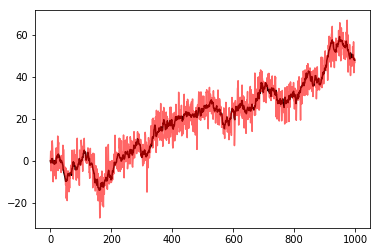

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# simulate the data from the assumed model
T = 1000;

X = np.zeros([T])
Y = np.zeros([T])

v = 5; # Standard deviation of the observation density

for t in range(1,T):
    X[t] = X[t-1] + np.random.normal(0,1) # Simulate from the transition model
    Y[t] = X[t] + np.random.normal(0,v) # Simulate from the observation density

plt.plot(X,'k')
plt.plot(Y,'r-',alpha = 0.6)
plt.show

Now we can see black signal $X_t$ and noisy signal $Y_t$ (surrounding red). Our aim is to solve the filtering problem: Given $Y_{1:t}$, we want to estimate $X_t$, i.e., we want to estimate the conditional mean of $p(x_t|y_{1:t})$. We are not going to deal with the specific relationship between particle filter and conditional density of the model, as there are many derivations of it on web.

Particle filter is a way to estimate $X_t$ given observations $Y_{1:t}$. The particle filter processes observations sequentially, meaning that upon receiving $Y_t$, it builds an estimate of $X_t$. It does so in three steps,

\begin{align*}
\hat{X}_t^{(i)} &= X_{t-1}^{(i)} + W_t \\
w_t^{(i)} &\propto p(y_t|\hat{X}_t^{(i)}) \\
X_t^{(i)} &\sim \{w_t^{(i)},\hat{X}_t^{(i)}\}
\end{align*}

In the quick-and-dirty nature of these notebooks, this explanation is very compact. To make short explanations: First step is simulation step for each particle: Since we assume this model, it makes sense to move particles according to dynamics. Second step, the weighting step, contains implicit computations as you can see below (for numerical stability). Simply, we compute weights proportional to likelihood of the proposed particles. Third step is the resampling step from the weighted distribution. For a proper explanation of these methods, see [here](http://www.almoststochastic.com/2013/08/sequential-importance-sampling.html) and for more intuition [here](http://www.almoststochastic.com/2016/10/a-primer-on-filtering.html) (my blog).

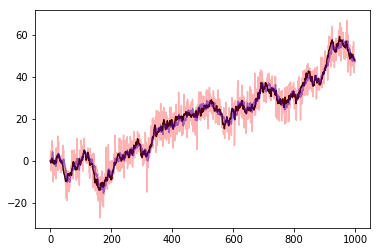

In [4]:
def resample(Xp,w):
    N = np.size(Xp)
    return np.random.choice(np.array(Xp),N,replace=True,p=w)

# Particle filter
v2 = pow(v,2); # Variance - Will be necessary for computing weights

N = 100 # The number of particles

Xp = np.zeros([N])
logW = np.ones([N])
W = np.ones([N])
Xm = np.zeros([T])

for t in range(0,T):
    Xp = Xp + np.random.normal(0,1,[N]) # Transition step
        
    logW = [-0.5 * (1/v2) * np.power((Y[t] - x),2) for x in Xp] # Computing log weights for numerical stability
        
    W = np.exp(logW - np.max(logW)) # A trick to compute numerically stable unnormalised weights
    
    w = np.divide(W,np.sum(W))
    
    Xm[t] = np.sum(np.multiply(w,Xp)) # Weighted mean estimate, i.e., the estimate of the conditional mean
    
    Xp = resample(Xp,w) # Resampling


plt.plot(X,'k')
plt.plot(Xm,'b-',alpha=0.5)
plt.plot(Y,'r',alpha=0.3)
plt.show()